# Part-04A: Deep NLP Text Preparation

## Introduction

Deep learning models have shown great potential in processing and understanding large volumes of text data. This notebook is dedicated to preparing text data for deep learning models using TensorFlow. We will cover essential steps such as creating train-test-validation splits, using Keras' TextVectorization layer, and building and evaluating various neural network models.

#### Objectives

1. **Prepare Data for Deep Learning**:
   - Load and preprocess the Amazon Product Reviews dataset.
   - Create train-test-validation splits to ensure robust model training and evaluation.

2. **Text Vectorization**:
   - Utilize Keras' TextVectorization layer to convert raw text into sequences of integers.
   - Determine appropriate sequence lengths and batch the data for efficient processing.

3. **Use Pre-trained Word Embeddings**:
   - Load and utilize pre-trained GloVe word embeddings to enrich the text data with semantic information.
   - Perform operations such as similarity checks and word arithmetic to explore the embeddings.

4. **Build and Evaluate Neural Network Models**:
   - Build and compile various neural network architectures, including Simple RNN, LSTM, GRU, and Attention models.
   - Train the models using the prepared data and evaluate their performance using appropriate metrics.

By the end of this notebook, we will have a set of well-prepared text data and trained deep learning models ready for further analysis and deployment. This preparation ensures that our models can effectively process and understand the text data, providing valuable insights and accurate predictions.


In [1]:
# Adding parent directory to python path
import sys, os
sys.path.append( os.path.abspath('../'))

In [2]:
# # %conda install -y apple::tensorflow-deps
# !python3 -m pip install tensorflow-macos
# # !python3 -m pip install tensorflow-metal

In [3]:
## Load the autoreload extension
!pip install -U dojo_ds
import dojo_ds as ds
ds.__version__
# %load_ext autoreload 
# %autoreload 2

# import custom_functions_SOLUTION  as fn

'1.1.15'

## Data

In [4]:
from IPython.display import display, Markdown
with open("data/Amazon Product Reviews.md") as f:
    display(Markdown(f.read()))

# Amazon Product Reviews

- URL: https://cseweb.ucsd.edu/~jmcauley/datasets.html#amazon_reviews 

## Description

This is a large crawl of product reviews from Amazon. This dataset contains 82.83 million unique reviews, from around 20 million users.

## Basic statistics

| Ratings:  | 82.83 million        |
| --------- | -------------------- |
| Users:    | 20.98 million        |
| Items:    | 9.35 million         |
| Timespan: | May 1996 - July 2014 |

## Metadata

- reviews and ratings
- item-to-item relationships (e.g. "people who bought X also bought Y")
- timestamps
- helpfulness votes
- product image (and CNN features)
- price
- category
- salesRank

## Example

```
{  "reviewerID": "A2SUAM1J3GNN3B",  "asin": "0000013714",  "reviewerName": "J. McDonald",  "helpful": [2, 3],  "reviewText": "I bought this for my husband who plays the piano.  He is having a wonderful time playing these old hymns.  The music  is at times hard to read because we think the book was published for singing from more than playing from.  Great purchase though!",  "overall": 5.0,  "summary": "Heavenly Highway Hymns",  "unixReviewTime": 1252800000,  "reviewTime": "09 13, 2009" }
```

## Download link

See the [Amazon Dataset Page](https://cseweb.ucsd.edu/~jmcauley/datasets/amazon_v2/) for download information.

The 2014 version of this dataset is [also available](https://cseweb.ucsd.edu/~jmcauley/datasets/amazon/links.html).

## Citation

Please cite the following if you use the data:

**Ups and downs: Modeling the visual evolution of fashion trends with one-class collaborative filtering**

R. He, J. McAuley

*WWW*, 2016
[pdf](https://cseweb.ucsd.edu/~jmcauley/pdfs/www16a.pdf)

**Image-based recommendations on styles and substitutes**

J. McAuley, C. Targett, J. Shi, A. van den Hengel

*SIGIR*, 2015
[pdf](https://cseweb.ucsd.edu/~jmcauley/pdfs/sigir15.pdf)

In [5]:
# !pip install tensorflow-macos"<2.13"
# !pip install tensorflow-metal
# !pip install tf_keras

In [6]:
# conda list tensorflow

In [7]:
# %pip install  tensorflow-macos --upgrade
# %pip install  tensorflow-metal --upgrade

In [8]:
import sys, os


# os.environ['TF_USE_LEGACY_KERAS']='1'


import tensorflow as tf
import numpy as np

# Then Set Random Seeds
tf.keras.utils.set_random_seed(42)
tf.random.set_seed(42)
np.random.seed(42)
# Then run the Enable Deterministic Operations Function
tf.config.experimental.enable_op_determinism()

# MacOS Sonoma Fix
tf.config.set_visible_devices([], 'GPU')
print(f"{tf.__version__=}")

tf.__version__='2.16.2'


In [9]:
import pandas as pd 
import seaborn as sns

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


from tensorflow.keras.layers import TextVectorization
from tensorflow.keras import layers
from tensorflow.keras import optimizers

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import GridSearchCV
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import LabelEncoder
from sklearn import set_config
set_config(transform_output='pandas')
pd.set_option('display.max_colwidth', 250)

# Define a function for building an LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, optimizers, regularizers

In [10]:
import json, joblib
with open("config/filepaths.json") as f:
    FPATHS = json.load(f)
FPATHS['data']['ml-nlp']

{'train_joblib': 'data/modeling/training-data.joblib',
 'test_joblib': 'data/modeling/testing-data.joblib'}

In [11]:
## Load the autoreload extension
!pip install -U dojo_ds
import dojo_ds as fn
# %load_ext autoreload 
# %autoreload 2

# import custom_functions_SOLUTION  as fn

## Function Code

In [12]:
fn.show_code(fn.evaluate.evaluate_classification_network)
fn.show_code(fn.evaluate.classification_metrics)
fn.show_code(fn.evaluate.convert_y_to_sklearn_classes)

```python
def evaluate_classification_network(model, 
                                    X_train=None, y_train=None, 
                                    X_test=None, y_test=None,
                                    history=None, history_figsize=(6,6),
                                    figsize=(6,4), normalize='true',
                                    output_dict = False,
                                    cmap_train='Blues',
                                    cmap_test="Reds",
                                    values_format=".2f", 
                                    colorbar=False, target_names=None, 
         return_fig=False):
    """Evaluates a neural network classification task using either
    separate X and y arrays or a tensorflow Dataset

    Args:
        model (sklearn-compatible classifier): Model to evaluate.
        X_train (array or tf.data.Dataset, optional): Training data. Defaults to None.
        y_train (array, or None if X_train is a tf Dataset, optional): Training labels (if not using a tf dataset). Defaults to None.
        X_test (array or tf.data.Dataset, optional): Test data. Defaults to None.
        y_test (array, or None if X_test is a tf Dataset, optional): Test labels (if not using a tf Dataset). Defaults to None.
        history (tensorflow history object, optional): History object from model training. Defaults to None.
        history_figsize (tuple, optional): Total figure size for plot_history. Defaults to (6,8).
        figsize (tuple, optional): figsize for confusion matrix subplots. Defaults to (6,4).
        normalize (str, optional): arg for sklearn's ConfusionMatrixDisplay. Defaults to 'true' (conf mat values normalized to true class).  
        output_dict (bool, optional):  Return the results of classification_report as a dict. Defaults to False. Defaults to False.
        cmap_train (str, optional): Colormap for the ConfusionMatrixDisplay for training data. Defaults to 'Blues'.
        cmap_test (str, optional): Colormap for the ConfusionMatrixDisplay for test data.  Defaults to "Reds".
        colorbar (bool, optional): Arg for ConfusionMatrixDispaly: include colorbar or not. Defaults to False.
        values_format (str, optional): Format values on confusion matrix. Defaults to ".2f".
        target_names (array, optional): Text labels for the integer-encoded target. Passed in numeric order [label for "0", label for "1", etc.]
        return_fig (bool, optional): Whether the matplotlib figure for confusion matrix is returned. Defaults to False.
                                          Note: Must set outout_dict to False and set return_fig to True to get figure returned.


     Returns (Only 1 value is returned, but contents vary):
        dict: Dictionary that contains results for "train" and "test. 
            Contents of dictionary depending on output_dict and return_fig:
              - if output_dict==True and return_fig==False: returns dictionary of classification report results
            - if output_dict==False and return_fig==True: returns dictionary of confusion matrix displays.
    """
    if (X_train is None) & (X_test is None):
        raise Exception('\nEither X_train & y_train or X_test & y_test must be provided.')
 
    shared_kwargs = dict(output_dict=True, 
                      figsize=figsize,
                      colorbar=colorbar,
                      values_format=values_format, 
                      target_names=target_names,)
    # Plot history, if provided
    if history is not None:
        plot_history(history, figsize=history_figsize)
    ## Adding a Print Header
    print("\n"+'='*80)
    print('- Evaluating Network...')
    print('='*80)
    ## TRAINING DATA EVALUATION
    # check if X_train was provided
    if X_train is not None:
        ## Check if X_train is a dataset
        # if hasattr(X_train,'map'):
        type_str = str(type(X_train))
        if type_str.startswith("tensorflow") or "dataset" in type_str.lower():
            # If it IS a Datset:
            # extract y_train and y_train_pred with helper function
            y_train, y_train_pred = get_true_pred_labels(model, X_train)
        else:
            # Get predictions for training data
            y_train_pred = model.predict(X_train)
        ## Pass both y-vars through helper compatibility function
        y_train = convert_y_to_sklearn_classes(y_train)
        y_train_pred = convert_y_to_sklearn_classes(y_train_pred)
        
        # Call the helper function to obtain regression metrics for training data
        results_train = classification_metrics(y_train, y_train_pred, cmap=cmap_train,label='Training Data', **shared_kwargs)
        
        ## Run model.evaluate         
        print("\n- Evaluating Training Data:")
        print(model.evaluate(X_train, return_dict=True))
    
    # If no X_train, then save empty list for results_train
    else:
        results_train = None
  
  
    ## TEST DATA EVALUATION
    # check if X_test was provided
    if X_test is not None:
        ## Check if X_train is a dataset
        if hasattr(X_test,'map'):
            # If it IS a Datset:
            # extract y_train and y_train_pred with helper function
            y_test, y_test_pred = get_true_pred_labels(model, X_test)
        else:
            # Get predictions for training data
            y_test_pred = model.predict(X_test)
        ## Pass both y-vars through helper compatibility function
        y_test = convert_y_to_sklearn_classes(y_test)
        y_test_pred = convert_y_to_sklearn_classes(y_test_pred)
        
        # Call the helper function to obtain regression metrics for training data
        results_test = classification_metrics(y_test, y_test_pred, cmap=cmap_test,label='Test Data', **shared_kwargs)
        
        ## Run model.evaluate         
        print("\n- Evaluating Test Data:")
        print(model.evaluate(X_test, return_dict=True))
      
    # If no X_test, then save empty list for results_test
    else:
        results_test = None
      
    if (output_dict == True) | (return_fig==True):
        # Store results in a dataframe if ouput_frame is True
        results_dict = {'train':results_train,
                        'test': results_test}
        return results_dict

```

```python
def classification_metrics(y_true, y_pred, label='',
                           output_dict=False, figsize=(8,4),
                           normalize='true', cmap='Blues',
                           colorbar=False, values_format=".2f",
                           target_names = None, return_fig=True):
    """
    Calculate classification metrics from predictions and display Confusion matrix.

    Args:
        y_true (Series/array): True target values.
        y_pred (Series/array): Predicted target values.
        label (str, optional): Label for printed header. Defaults to ''.
        output_dict (bool, optional): Return the results of classification_report as a dict. Defaults to False.
        figsize (tuple, optional): figsize for confusion matrix subplots. Defaults to (8,4).
        normalize (str, optional): Arg for sklearn's ConfusionMatrixDisplay. Defaults to 'true' (conf mat values normalized to true class).
        cmap (str, optional): Colormap for the ConfusionMatrixDisplay. Defaults to 'Blues'.
        colorbar (bool, optional): Arg for ConfusionMatrixDisplay: include colorbar or not. Defaults to False.
        values_format (str, optional): Format values on confusion matrix. Defaults to ".2f".
        target_names (array, optional): Text labels for the integer-encoded target. Passed in numeric order [label for "0", label for "1", etc.].
        return_fig (bool, optional): To get matplotlib figure for confusion matrix, set output_dict to False and set return_fig to True.

    Returns:
        dict: Dictionary from classification_report. Only returned if output_dict=True.
        fig: Matplotlib figure with confusion matrix. Only returned if output_dict=False and return_fig=True.

    Note: 
        This is a modified version of the classification metrics function from Intro to Machine Learning.
        Updates:
          - Reversed raw counts confusion matrix cmap (so darker==more).
          - Added arg for normalized confusion matrix values_format.
    """
    from sklearn.metrics import classification_report, ConfusionMatrixDisplay
    import matplotlib.pyplot as plt
    import numpy as np
    # Get the classification report
    report = classification_report(y_true, y_pred,target_names=target_names)
    
    ## Print header and report
    header = "-"*70
    print(header, f" Classification Metrics: {label}", header, sep='\n')
    print(report)
    
    ## CONFUSION MATRICES SUBPLOTS
    fig, axes = plt.subplots(ncols=2, figsize=figsize)
    
    # Create a confusion matrix of raw counts (left subplot)
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                                            normalize=None, 
                                            cmap='gist_gray_r',# Updated cmap
                                            values_format="d", 
                                            colorbar=colorbar,
                                            ax = axes[0], 
                                            display_labels=target_names);
    axes[0].set_title("Raw Counts")
    
    # Create a confusion matrix with the data with normalize argument 
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                                            normalize=normalize,
                                            cmap=cmap, 
                                            values_format=values_format, #New arg
                                            colorbar=colorbar,
                                            ax = axes[1],
                                            display_labels=target_names);
    axes[1].set_title("Normalized Confusion Matrix")
    
    # Adjust layout and show figure
    fig.tight_layout()
    plt.show()
    
    # Return dictionary of classification_report
    if output_dict==True:
        report_dict = classification_report(y_true, y_pred,target_names=target_names, output_dict=True)
        return report_dict

    elif return_fig == True:
        return fig

```

```python
def convert_y_to_sklearn_classes(y, verbose=False):
    """
    Helper function to convert neural network outputs to class labels.

    Args:
        y (array/Series): Predictions to convert to classes.
        verbose (bool, optional): Print which preprocessing approach is used. Defaults to False.

    Returns:
        array: Target as 1D class labels
    """
    import numpy as np

    # If already one-dimension
    if np.ndim(y) == 1:
        if verbose:
            print("- y is 1D, using it as-is.")
        return y

    # If 2 dimensions with more than 1 column:
    elif y.shape[1] > 1:
        if verbose:
            print("- y is 2D with >1 column. Using argmax for metrics.")
        return np.argmax(y, axis=1)

    else:
        if verbose:
            print("y is 2D with 1 column. Using round for metrics.")
        return np.round(y).flatten().astype(int)

```

## From Train-Test Split for ML to Train-Test-Val Split for ANNs

In [13]:
X_train, y_train = joblib.load(FPATHS['data']['ml-nlp']['train_joblib'])
X_test, y_test = joblib.load(FPATHS['data']['ml-nlp']['test_joblib'])

- Can't use text labels with neural networks.

In [14]:
# Instansiate label encoder
# encoder = joblib.load()...LabelEncoder()

In [15]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
import joblib

In [16]:
'encoder' in str(FPATHS)#['models'][ml]

True

In [17]:
encoder=  joblib.load(FPATHS['metadata']['label_encoder_joblib'])
encoder

LabelEncoder()

In [18]:
# encoder = joblib.load(FPATHS['models']['ml']['encoder'])

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

        High       0.97      0.98      0.98      1376
         Low       0.97      0.96      0.97      1102

    accuracy                           0.97      2478
   macro avg       0.97      0.97      0.97      2478
weighted avg       0.97      0.97      0.97      2478



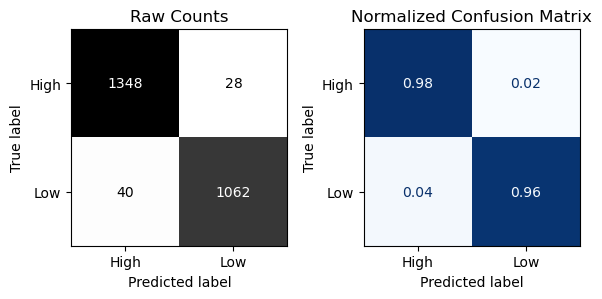


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

        High       0.93      0.98      0.96       492
         Low       0.96      0.90      0.93       335

    accuracy                           0.95       827
   macro avg       0.95      0.94      0.94       827
weighted avg       0.95      0.95      0.95       827



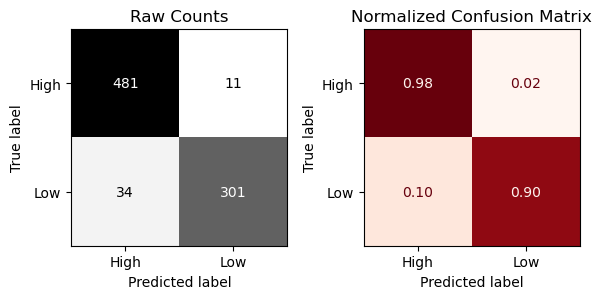

In [19]:
## Create a model pipeline 
count_pipe = Pipeline([('vectorizer',  CountVectorizer()), 
                       ('naivebayes',  MultinomialNB())])

count_pipe.fit(X_train, y_train)
fn.evaluate.evaluate_classification(count_pipe, X_train, y_train, X_test, y_test,target_names=encoder.classes_)

In [20]:
# # Admin: Saving  for Demo functions in part 1
# import joblib
# fpath_joblib = "../Lecture 1 Pt1 - Making a Custom Module/example-clf-model-with-data.joblib"
# save_for_part1= {'model':count_pipe, 'training data': [X_train, y_train],'test data':[X_test, y_test]}
# joblib.dump(save_for_part1, fpath_joblib)

# Preparing For Deep NLP (Train-Test-Val Datasets)

## Prepare Tensorflow Datasets

Since we already have train/test X and y vars, we will make 2 dataset objects using tf.data.Dataset.from_tensor_slices.

1. The training dataset using X_train, y_train (that we resampled/balanced)
2. The val/test dataset using X_test, y-test.

We will then split the val/test dataset into a val/test split.

<!-- 
### T/T/V Split - Order of Operations (if using 1 dataset object)

1) **Create full dataset object & Shuffle Once.**
2) Calculate number of samples for training and validation data.
3) Create the train/test/val splits using .take() and .skip()
4) **Add shuffle to the train dataset only.**
5) (Optional/Not Used on LP) If applying a transformation (e.g. train_ds.map(...)) to the data, add  here, before .cache()
7) (Optional) Add .cache() to all splits to increase speed  (but may cause problems with large datasets)
8) **Add .batch to all splits (default batch size=32)**
9) (Optional) Add .prefetch(tf.data.AUTOTUNE)
10) (Optional) Print out final length of datasets -->

In [21]:
# Convert training data to Dataset Object
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
# Shuffle dataset once
train_ds = train_ds.shuffle(buffer_size=len(train_ds),
                            reshuffle_each_iteration=False, seed=321)

Create a test and validation dataset using X_test,y_test

In [22]:
# Convert test to dataset object and split
val_test_split_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))
val_test_split_ds

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [23]:
# Calculate # of samples for 50/50 val/test split
n_val_samples =  int(len(val_test_split_ds) * .5)
n_val_samples

413

In [24]:
## Perform the val/test split
## Create the validation dataset
val_ds = val_test_split_ds.take(n_val_samples)

## Create the test dataset
test_ds = val_test_split_ds.skip(n_val_samples)

In [25]:
# Comparing the len gths of all 3 splits
len(train_ds), len(val_ds), len(test_ds)

(2478, 413, 414)

In [26]:
# Shuffle only the training data every epoch
train_ds = train_ds.shuffle(len(train_ds), seed=321)

In [27]:
#  Setting the batch_size for all datasets
BATCH_SIZE = 32

# use .batch to add batching to all 3 datasets
train_ds = train_ds.batch(BATCH_SIZE)
val_ds = val_ds.batch(BATCH_SIZE)
test_ds = test_ds.batch(BATCH_SIZE)


# Confirm the number of batches in each
print (f' There are {len(train_ds)} training batches.')
print (f' There are {len(val_ds)} validation batches.')
print (f' There are {len(test_ds)} testing batches.')

 There are 78 training batches.
 There are 13 validation batches.
 There are 13 testing batches.


In [28]:
# taking a sample - now 32 observations instead of 1
example_X, example_y= train_ds.take(1).get_single_element()
print(example_X,'\n\n',example_y)

tf.Tensor(
[b"I have used this product before so I'm familiar with the preparation process and love that I can eat pasta with sauces I missed: Cheaper than anywhere else, I have used this product before so I'm familiar with the preparation process and love that I can eat pasta with sauces I missed for so long and not worry about the calories, sugars, and carbs. Will continue to be a loyal customer and would love if the buns were this affordable!"
 b"Excellant: Excellent as usual, anything I buy from Amazon always meets my expectations, the movies I bought, the noodles, everything I've gotten so far has always been great, I'm even feeding the rice I bought to my dogs so they don't get fat, thank you Amazon, I'm also losing weight like dr. Oz said, that's how I found the noodles in the first place, thanks Amazon again."
 b"1\\2 as much: Love these noodles, been buying locally for years and they were a bit cheaper with free shipping. ( no brainer )\nOnce we opened the one of the pack ther

A single element now contains 32 samples since we set  batch_size to 32.

In [29]:
## Saving Train and test dataset
fname_train_ds = FPATHS['data']['nn-nlp']['train_dir']
train_ds.save(path=fname_train_ds,)

fname_val_ds = FPATHS['data']['nn-nlp']['val_dir']
val_ds.save(path=fname_val_ds,)

fname_test_ds = FPATHS['data']['nn-nlp']['test_dir']
test_ds.save(path=fname_test_ds,)

## Word Embeddings Demo (Pre-Trained)

###  Pretrianed Word Embeddings with GloVe

- [Click here](https://nlp.stanford.edu/data/glove.6B.zip) to start donwnloading GloVe zip file (glove.6B.zip)
- Unzip the downloaded zip archive.
- Open the extracted folder and find the the `glove.6B.100d.txt` file. (Size is over 300MB )
- Move the text file from Downloads to the same folder as this notebook.
- **Make sure to ignore the large file using GitHub Desktop**

In [30]:
%conda list scipy

# scipy==1.10.1

# packages in environment at /opt/homebrew/Caskroom/miniforge/base/envs/dojo-env:
#
# Name                    Version                   Build  Channel
scipy                     1.12.0                   pypi_0    pypi

Note: you may need to restart the kernel to use updated packages.


In [31]:
# to get around scipy erorr when importing KeyedVectors from gensim
!pip install scipy==1.12

In [32]:
# %pip install scipy==1.12.0
# %pip install -U gensim

In [33]:
from gensim.models import KeyedVectors
# Load GloVe vectors into a gensim model
glove_model = KeyedVectors.load_word2vec_format("data/glove/glove.6B.100d.txt", binary=False, no_header=True)

In [34]:
# You can now use `glove_model` to access individual word vectors, similar to a dictionary
vector = glove_model['king']
vector

array([-0.32307 , -0.87616 ,  0.21977 ,  0.25268 ,  0.22976 ,  0.7388  ,
       -0.37954 , -0.35307 , -0.84369 , -1.1113  , -0.30266 ,  0.33178 ,
       -0.25113 ,  0.30448 , -0.077491, -0.89815 ,  0.092496, -1.1407  ,
       -0.58324 ,  0.66869 , -0.23122 , -0.95855 ,  0.28262 , -0.078848,
        0.75315 ,  0.26584 ,  0.3422  , -0.33949 ,  0.95608 ,  0.065641,
        0.45747 ,  0.39835 ,  0.57965 ,  0.39267 , -0.21851 ,  0.58795 ,
       -0.55999 ,  0.63368 , -0.043983, -0.68731 , -0.37841 ,  0.38026 ,
        0.61641 , -0.88269 , -0.12346 , -0.37928 , -0.38318 ,  0.23868 ,
        0.6685  , -0.43321 , -0.11065 ,  0.081723,  1.1569  ,  0.78958 ,
       -0.21223 , -2.3211  , -0.67806 ,  0.44561 ,  0.65707 ,  0.1045  ,
        0.46217 ,  0.19912 ,  0.25802 ,  0.057194,  0.53443 , -0.43133 ,
       -0.34311 ,  0.59789 , -0.58417 ,  0.068995,  0.23944 , -0.85181 ,
        0.30379 , -0.34177 , -0.25746 , -0.031101, -0.16285 ,  0.45169 ,
       -0.91627 ,  0.64521 ,  0.73281 , -0.22752 , 

In [35]:
vector.shape

(100,)

In [36]:
# Find similarity between words
glove_model.similarity('king', 'queen')

0.7507691

In [37]:
# Perform word math
result = glove_model.most_similar(positive=['woman', 'king'], negative=['man'], topn=5)
result

[('queen', 0.7698541283607483),
 ('monarch', 0.6843380331993103),
 ('throne', 0.6755736470222473),
 ('daughter', 0.6594556570053101),
 ('princess', 0.6520534157752991)]

In [38]:
# We can use glove to calculate the most similar
glove_model.most_similar('king')

[('prince', 0.7682329416275024),
 ('queen', 0.7507689595222473),
 ('son', 0.7020888328552246),
 ('brother', 0.6985775828361511),
 ('monarch', 0.6977890729904175),
 ('throne', 0.691999077796936),
 ('kingdom', 0.6811410188674927),
 ('father', 0.6802029013633728),
 ('emperor', 0.6712858080863953),
 ('ii', 0.6676074266433716)]

In [39]:
# Manually calculating new vector for word math
new_vector = glove_model['king'] - glove_model['man'] + glove_model['woman']
new_vector

array([-0.10231996, -0.81294006,  0.10211003,  0.985924  ,  0.34218282,
        1.09095   , -0.48912996, -0.05616698, -0.21029997, -1.02996   ,
       -0.86851   ,  0.36786997,  0.01960999,  0.59259   , -0.23190099,
       -1.016919  , -0.01218399, -1.17194   , -0.52329   ,  0.60645   ,
       -0.98537004, -1.001028  ,  0.48913902,  0.630072  ,  0.58224   ,
        0.15908998,  0.43685   , -1.25351   ,  0.97054   , -0.065529  ,
        0.733763  ,  0.44219002,  1.2091839 ,  0.19698   , -0.15948   ,
        0.34364003, -0.46222997,  0.33772   ,  0.14792705, -0.24959502,
       -0.77093005,  0.522717  , -0.1283    , -0.91881   , -0.01755001,
       -0.44041002, -0.52656496,  0.33734798,  0.60639   , -0.45067   ,
       -0.04158002,  0.08408299,  1.31456   ,  0.67737997, -0.24316001,
       -2.071     , -0.60648996,  0.19710997,  0.63567   ,  0.07819998,
        0.49161002,  0.08171999,  0.70855707,  0.201938  ,  0.5155501 ,
       -0.23025298, -0.40473002,  0.39212003, -0.5093    , -0.13

In [40]:
# Using .most_similar with an array
glove_model.most_similar(new_vector)

[('king', 0.8551837205886841),
 ('queen', 0.7834413647651672),
 ('monarch', 0.6933802366256714),
 ('throne', 0.6833109259605408),
 ('daughter', 0.680908203125),
 ('prince', 0.6713142991065979),
 ('princess', 0.664408266544342),
 ('mother', 0.6579325199127197),
 ('elizabeth', 0.6563301086425781),
 ('father', 0.6392418742179871)]

In [41]:
# Manually calculating new vector for word math
new_vector = glove_model['monarchy'] + glove_model['vote'] + glove_model['government']
glove_model.most_similar(new_vector)

[('government', 0.8555272221565247),
 ('elections', 0.8260869979858398),
 ('vote', 0.821299135684967),
 ('election', 0.7950962781906128),
 ('rule', 0.7902188897132874),
 ('opposition', 0.7764408588409424),
 ('parliament', 0.7697930335998535),
 ('ruling', 0.7695497274398804),
 ('party', 0.7599928379058838),
 ('monarchy', 0.7500120401382446)]

In [42]:
# Manually calculating new vector for word math
new_vector = glove_model['baby'] + glove_model['age']
glove_model.most_similar(new_vector)

[('age', 0.8743536472320557),
 ('baby', 0.8642442226409912),
 ('child', 0.795682430267334),
 ('children', 0.7709920406341553),
 ('older', 0.7629886269569397),
 ('girl', 0.7522111535072327),
 ('mother', 0.7367070317268372),
 ('boy', 0.7361041307449341),
 ('birth', 0.7357129454612732),
 ('couple', 0.7255393266677856)]

In [43]:
# Manually calculating new vector for word math
new_vector = glove_model['baby'] + glove_model['baby']
glove_model.most_similar(new_vector)

[('baby', 0.9999999403953552),
 ('babies', 0.7870863676071167),
 ('newborn', 0.7522428035736084),
 ('boy', 0.7506729364395142),
 ('girl', 0.7423104047775269),
 ('child', 0.7266175746917725),
 ('infant', 0.7064839005470276),
 ('mom', 0.699421226978302),
 ('pregnant', 0.6986744403839111),
 ('toddler', 0.6978277564048767)]

# Returning to Amazon Data

### Create the Training Texts Dataset

In [44]:
# Fit the layer on the training texts
try:
    sequence_vectorizer.adapt(train_ds)
except Exception as e:
    display(e)

NameError("name 'sequence_vectorizer' is not defined")

> We need to get a version of our data that is **only the texts**.

In [45]:
# Get just the text from ds_train
ds_texts = train_ds.map(lambda x, y: x)

# Preview the text
ds_texts.take(1).get_single_element()

<tf.Tensor: shape=(32,), dtype=string, numpy=
array([b'Two Stars: Cooking process to long and complicated.',
       b'One Star: horrible',
       b'Love these low-carb low-calorie noodles: Love these low-carb low-calorie noodles. Sticking to a low-carb diet is really hard and these noodles make it possible for me',
       b'Superior choice over wheat pastas: Had these before and wasn\'t particularly impressed. Then gave them another chance once I realized I can\'t eat wheat. I found that if you follow instructions - who knew!? - and rinsed them and pan dried them before use, they\'re great! Tasteless on their own, they absorb the sauces you might use and are wonderful in a bowl of "Pho" or soups. The best part is that I get that satisfying sense of noodles and the health benefit of adding a beneficial fiber to my diet that actually feeds the good gut bacteria in the gut. Bonus! No calories!',
       b'One Star: The texture of these rice and noodles were terrible.  It had completely no 

### Determine appropriate sequence length. 

In [46]:
# df_ml['length (characters)'] = df_ml['text'].map(len)
# df_ml.head(3)

# ax = sns.histplot(data=df_ml, hue='rating', x='length (characters)',
#                 stat='percent',common_norm=False)#, estimator='median',);
# ax.axvline()

In [47]:
sequence_lengths = X_train.map(lambda x: len(x.split(" ")))
sequence_lengths.describe()

count    2478.000000
mean       49.979822
std        60.989205
min         2.000000
25%        13.000000
50%        33.000000
75%        63.000000
max       977.000000
Name: review-text-full, dtype: float64

In [48]:
ax = sns

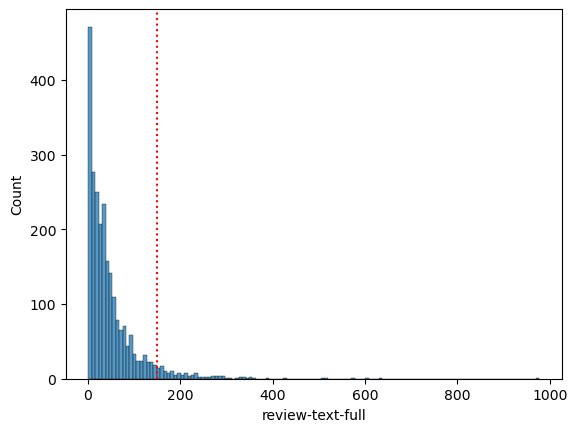

In [49]:
SEQUENCE_LENGTH = 150
ax = sns.histplot(data=sequence_lengths,)# hue='target-rating', x='length (tokens)',kde=True,
                # stat='probability',common_norm=False)#, estimator='median',);
ax.axvline(SEQUENCE_LENGTH, color='red', ls=":")

In [50]:

## Create text Vectorization layer
SEQUENCE_LENGTH=50 #BEST=50
EMBED_DIM = 100 # BEST= 200

sequence_vectorizer = tf.keras.layers.TextVectorization(
    standardize="lower_and_strip_punctuation",
    output_mode="int",
    output_sequence_length=SEQUENCE_LENGTH
)

sequence_vectorizer.adapt(ds_texts)


2024-09-05 12:14:20.516161: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


# Our First Deep Sequence Model

### Simple RNN

In [51]:

VOCAB_SIZE = sequence_vectorizer.vocabulary_size()
SEQUENCE_LENGTH = sequence_vectorizer.get_config()['output_sequence_length']


# Define sequential model with pre-trained vectorization layer and *new* embedding layer
model = Sequential([
    sequence_vectorizer,
    layers.Embedding(input_dim=VOCAB_SIZE,
                              output_dim=EMBED_DIM, 
                              input_length=SEQUENCE_LENGTH)
    ])

/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [52]:
### BEST


def build_rnn_model(text_vectorization_layer):
    VOCAB_SIZE = text_vectorization_layer.vocabulary_size()
    SEQUENCE_LENGTH = sequence_vectorizer.get_config()['output_sequence_length']
    
    
    # Define sequential model with pre-trained vectorization layer and *new* embedding layer
    model = Sequential([
        text_vectorization_layer,
        layers.Embedding(input_dim=VOCAB_SIZE,
                                  output_dim=EMBED_DIM, 
                                  input_length=SEQUENCE_LENGTH)
        ])
        
    # Add *new* LSTM layer
    model.add(layers.SimpleRNN(32)) #BEST=32
    
    # Add output layer
    model.add(layers.Dense(1, activation='sigmoid'))
 
    # Compile the model
    model.compile(optimizer=optimizers.Adam(learning_rate = .001), 
                  loss='bce',#'sparse_categorical_crossentropy', 
                  metrics=['accuracy'])
    
    model.summary()
    return model

# def get_callbacks(patience=3, monitor='val_accuracy'):
#     early_stop = tf.keras.callbacks.EarlyStopping(patience=patience, monitor=monitor)
#     return [early_stop]
# # Code below is from CNN Week
# def get_callbacks(patience=3, monitor='val_accuracy'):
#     early_stop = tf.keras.callbacks.EarlyStopping(patience=patience, monitor=monitor, verbose=True)
#     return [early_stop]


### Call backs
# @tf.function
def get_callbacks(monitor='val_accuracy',patience=3, restore_best_weights=False,
                  start_from_epoch=0,baseline_value=None,
                  verbose_early_stopping=1,  
                  tensborboard=False, logdir="/tmp/tb_logs",
                 tb_embed_freq=0, tb_write_images = False, tb_hist_freq = 0):

    early_stopping = tf.keras.callbacks.EarlyStopping(monitor=monitor, patience=patience, #mode=mode, 
                                                      restore_best_weights=restore_best_weights,
                                                      baseline=baseline_value,
                                                      start_from_epoch=start_from_epoch,
                                                      verbose=verbose_early_stopping)

    if tensborboard:
        tboard = tf.keras.callbacks.TensorBoard(log_dir=logdir, histogram_freq=tb_hist_freq,write_images=tb_write_images,
                                                embeddings_freq=tb_embed_freq,)
        return [ early_stopping, tboard]
    else:
        return [early_stopping]

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization              │ ?                      │   0 (unbuilt) │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6399 - loss: 0.6159 - val_accuracy: 0.8257 - val_loss: 0.4050
Epoch 2/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8963 - loss: 0.2779 - val_accuracy: 0.8692 - val_loss: 0.3559
Epoch 3/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9522 - loss: 0.1491 - val_accuracy: 0.8692 - val_loss: 0.3172
Epoch 4/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9842 - loss: 0.0715 - val_accuracy: 0.8402 - val_loss: 0.4186
Epoch 5/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9928 - loss: 0.0383 - val_accuracy: 0.8692 - val_loss: 0.3757
Epoch 6/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9939 - loss: 0.0262 - val_accuracy: 0.8620 - val_loss: 0.3658
Epoch 7/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9971 - loss: 0.0188 - val_accuracy: 0.8692 - val_loss: 0.4564
Epoch 7: early stopping


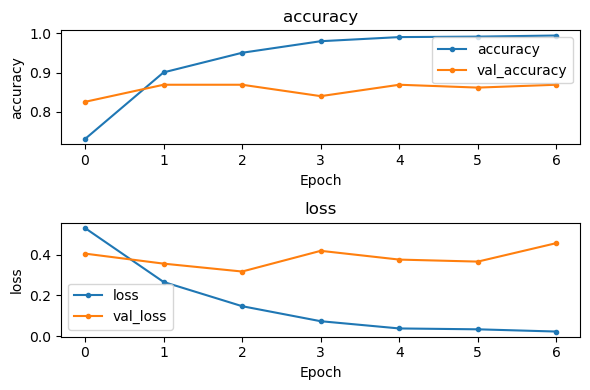

In [53]:
# Build the lstm model and specify the vectorizer
rnn_model = build_rnn_model(sequence_vectorizer)

# Defien number of epocs
EPOCHS = 30
# Fit the model
history = rnn_model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=get_callbacks(patience=5),
)
fn.evaluate.plot_history(history,figsize=(6,4))


- Evaluating Network...
----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1376
           1       1.00      0.99      1.00      1102

    accuracy                           1.00      2478
   macro avg       1.00      1.00      1.00      2478
weighted avg       1.00      1.00      1.00      2478



2024-09-05 12:14:31.110954: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


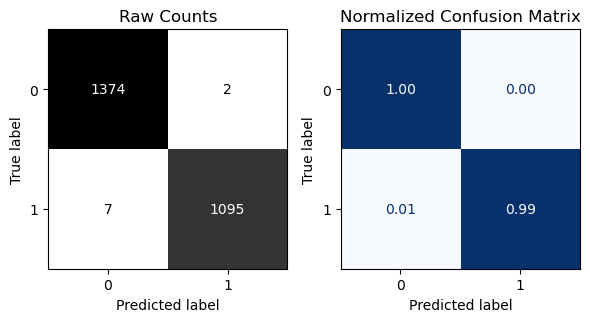


- Evaluating Training Data:
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9941 - loss: 0.0180
{'accuracy': 0.9963680505752563, 'loss': 0.015681255608797073}
----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.89      0.97      0.93       238
           1       0.95      0.85      0.89       176

    accuracy                           0.92       414
   macro avg       0.92      0.91      0.91       414
weighted avg       0.92      0.92      0.91       414



2024-09-05 12:14:32.191647: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


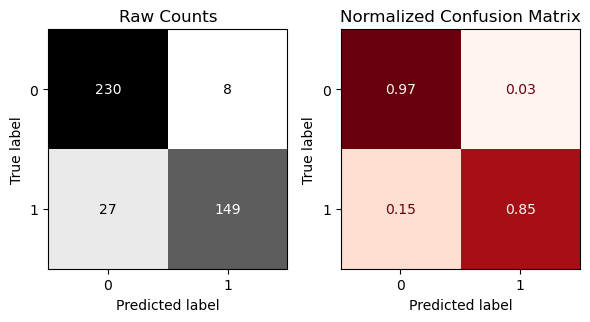


- Evaluating Test Data:
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9152 - loss: 0.2920
{'accuracy': 0.9154589176177979, 'loss': 0.2961035370826721}


In [54]:
# Obtain the results
results = fn.evaluate.evaluate_classification_network(
    rnn_model, X_train=train_ds, 
    X_test=test_ds,# history=history
);

## LSTM

In [55]:
# Define a function for building an LSTM model
from tensorflow.keras import layers, optimizers, regularizers
from tensorflow.keras.models import Sequential


# @tf.function
def build_lstm_model(text_vectorization_layer, binary_task=True):
    VOCAB_SIZE = text_vectorization_layer.vocabulary_size()

    if binary_task == True:
        final_activation = "sigmoid"  # ?
        loss_func = "binary_crossentropy"
        nunits_output = 1
    else:
        final_activation = "softmax"  # ?
        loss_func = "sparse_categorical_crossentropy"
        nunits_output = len(classes)

    # Define sequential model with pre-trained vectorization layer and *new* embedding layer
    lstm_model = Sequential(
        [
            text_vectorization_layer,
            layers.Embedding(
                input_dim=VOCAB_SIZE, output_dim=EMBED_DIM, input_length=SEQUENCE_LENGTH
            ),
        ]
    )

    # Add *new* LSTM layer
    lstm_model.add(layers.LSTM(64, recurrent_dropout=0.1, return_sequences=True))
    lstm_model.add(layers.Dropout(0.5))
    lstm_model.add(layers.LSTM(64, return_sequences=True))
    lstm_model.add(layers.GlobalMaxPooling1D())

    # Add output layer
    lstm_model.add(layers.Dense(nunits_output, activation=final_activation))

    # Compile the model
    lr_schedule = optimizers.schedules.ExponentialDecay(
        initial_learning_rate=0.01, decay_steps=10000, decay_rate=0.95
    )  # 0.9)
    optimizer = optimizers.Adam(learning_rate=lr_schedule)
    lstm_model.compile(
        optimizer=optimizer,  #'adam',
        loss=loss_func,  # "sparse_categorical_crossentropy",
        metrics=[  # tf.metrics.Accuracy(name='accuracy'),
            "accuracy",
            tf.metrics.Recall(name="recall")
            # tf.keras.metrics.Recall(class_id=0, name="recall_class_0"),
            # tf.keras.metrics.Recall(class_id=1, name="recall_class_1"),
        ],
    )

    lstm_model.summary()
    return lstm_model

/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization              │ (None, 50)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_2 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ ?                      │   0 (unbuilt) │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.7489 - loss: 0.5078 - recall: 0.6173 - val_accuracy: 0.8741 - val_loss: 0.3060 - val_recall: 0.7987
Epoch 2/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.9369 - loss: 0.1753 - recall: 0.9238 - val_accuracy: 0.8838 - val_loss: 0.3123 - val_recall: 0.7358
Epoch 3/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.9534 - loss: 0.1268 - recall: 0.9355 - val_accuracy: 0.9056 - val_loss: 0.2816 - val_recall: 0.9308
Epoch 4/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.9798 - loss: 0.0700 - recall: 0.9769 - val_accuracy: 0.8910 - val_loss: 0.2928 - val_recall: 0.7925
Epoch 5/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.9811 - loss: 0.0555 - recall: 0.9734 - val_accuracy: 0.8765 - val_loss: 0.3352 - val_recall: 0.7673
Epoch 6/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.9931 - loss: 0.0202 - recall: 0.9903 - val_accuracy: 0.9056 - val_loss: 0.3164 - val_recall: 0.9245
Epoch 6: e

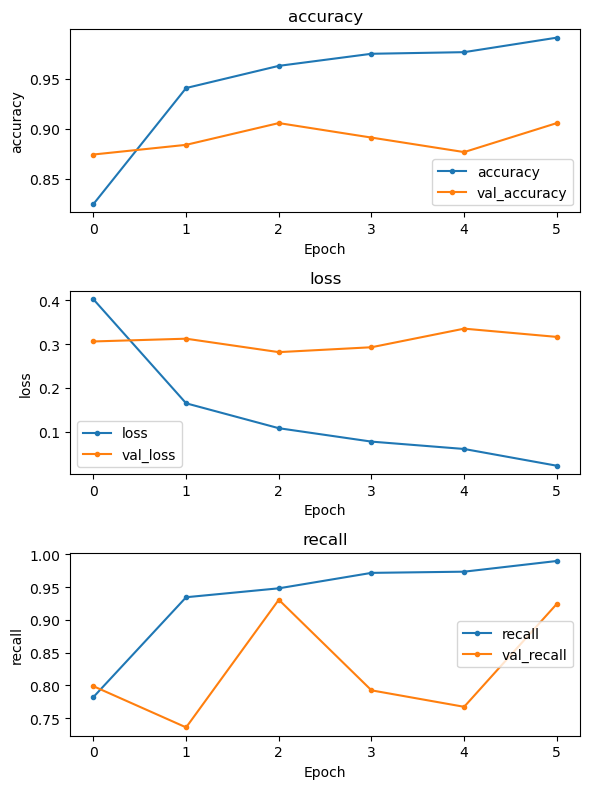

In [56]:
EMBED_DIM = 50
classes = y_train.unique()
# Build the lstm model and specify the vectorizer
lstm_model = build_lstm_model(sequence_vectorizer)

# Defien number of epocs
EPOCHS = 30

# Fit the model
history = lstm_model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=get_callbacks(),
)

fn.evaluate.plot_history(history)


- Evaluating Network...
----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1376
           1       0.99      1.00      1.00      1102

    accuracy                           1.00      2478
   macro avg       1.00      1.00      1.00      2478
weighted avg       1.00      1.00      1.00      2478



2024-09-05 12:14:55.627021: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


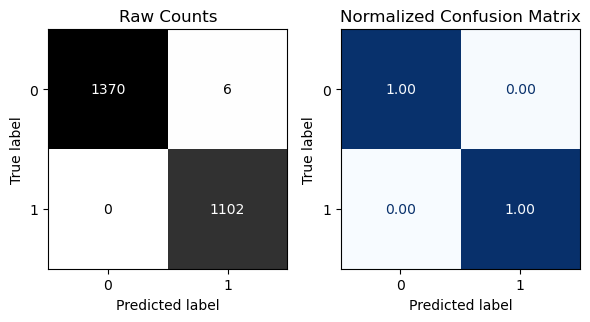


- Evaluating Training Data:
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9972 - loss: 0.0130 - recall: 1.0000
{'accuracy': 0.9975786805152893, 'loss': 0.012647964991629124, 'recall': 1.0}
----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.93      0.94      0.94       238
           1       0.92      0.91      0.91       176

    accuracy                           0.93       414
   macro avg       0.93      0.93      0.93       414
weighted avg       0.93      0.93      0.93       414



2024-09-05 12:14:57.522096: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


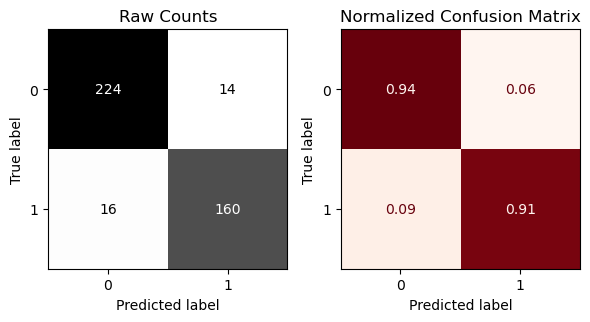


- Evaluating Test Data:
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9216 - loss: 0.2072 - recall: 0.9105
{'accuracy': 0.9275362491607666, 'loss': 0.20928291976451874, 'recall': 0.9090909361839294}


In [57]:
# Obtain the results
results = fn.evaluate.evaluate_classification_network(
    lstm_model, X_train=train_ds, 
    X_test=test_ds,# history=history
);

> ADD SAVING MODEL

In [58]:
# # Saving model in tf format 
# fname_model_lstm = FPATHS['models']['nn']['LSTM_dir']# "Models/keras/lstm/" # Filename is a folder for save_format='tf'
# lstm_model.save(fname_model_lstm, save_format='tf')

### RNN Model 2

In [59]:
def build_gru_model_bi_pool(text_vectorization_layer, binary_task=True):
    VOCAB_SIZE = text_vectorization_layer.vocabulary_size()
    
    if binary_task == True:
        final_activation = "sigmoid"  # ?
        loss_func = "binary_crossentropy"
        nunits_output = 1
    else:
        final_activation = "softmax"  # ?
        loss_func = "sparse_categorical_crossentropy"
        nunits_output = len(classes)
    
    # Define sequential model with pre-trained vectorization layer and *new* embedding layer
    model = Sequential(
        [
            text_vectorization_layer,
            layers.Embedding(
                input_dim=VOCAB_SIZE, output_dim=EMBED_DIM, input_length=SEQUENCE_LENGTH
            ),
        ]
    )
    model = Sequential([
        text_vectorization_layer,
        layers.Embedding(input_dim=VOCAB_SIZE,
                      output_dim=EMBED_DIM,
                      input_length=SEQUENCE_LENGTH)])
        
    # Add bidirectional component to GRU layer 
    model.add(layers.Bidirectional(layers.GRU(128, return_sequences = True)))
    
    # Add a pooling layer *new
    model.add(layers.GlobalMaxPooling1D())
    
    # Output layer
    model.add(layers.Dense(nunits_output, activation=final_activation))
                     
    # optimizer = optimizers.legacy.Adam()
    # Compile the model
    lr_schedule = optimizers.schedules.ExponentialDecay(
        initial_learning_rate=0.01, decay_steps=10000, decay_rate=0.95
    )  # 0.9)
    optimizer = optimizers.Adam(learning_rate=lr_schedule)
    model.compile(optimizer=optimizer, 
                  loss=loss_func,
                              metrics=[  # tf.metrics.Accuracy(name='accuracy'),
            "accuracy",
            tf.metrics.Recall(name="recall")
                              ])
    model.summary()
    return model

/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization              │ (None, 50)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_4 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_1          │ ?                      │   0 (unbuilt) │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.7764 - loss: 0.4481 - recall: 0.5687 - val_accuracy: 0.9104 - val_loss: 0.2141 - val_recall: 0.8742
Epoch 2/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - accuracy: 0.9525 - loss: 0.1238 - recall: 0.9393 - val_accuracy: 0.9177 - val_loss: 0.2084 - val_recall: 0.8994
Epoch 3/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - accuracy: 0.9869 - loss: 0.0341 - recall: 0.9825 - val_accuracy: 0.9225 - val_loss: 0.2008 - val_recall: 0.8679
Epoch 4/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - accuracy: 0.9995 - loss: 0.0097 - recall: 0.9999 - val_accuracy: 0.9298 - val_loss: 0.2330 - val_recall: 0.9434
Epoch 5/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - accuracy: 0.9997 - loss: 0.0031 - recall: 0.9998 - val_accuracy: 0.9177 - val_loss: 0.2827 - val_recall: 0.9245
Epoch 6/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - accuracy: 0.9994 - loss: 0.0033 - recall: 0.9997 - val_accuracy: 0.9080 - val_loss: 0.2989 - val_recall: 0.8553
Epoch 7/30

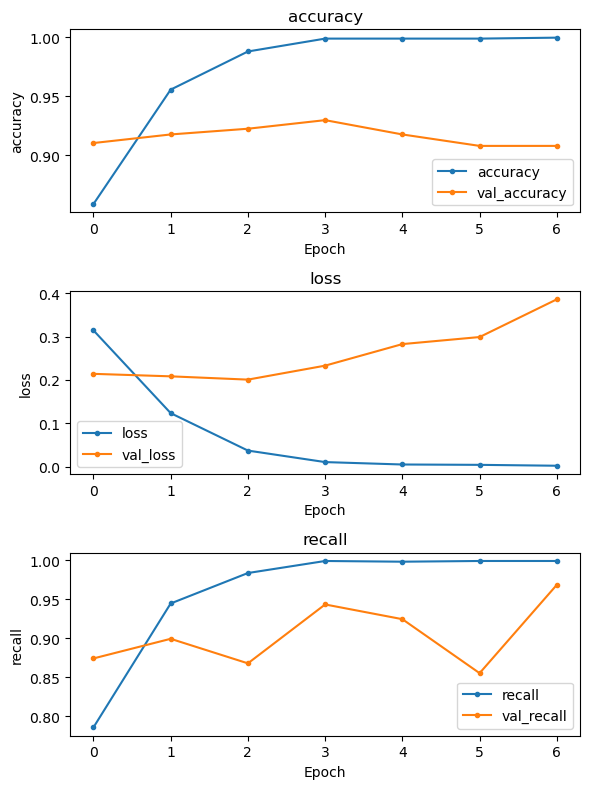

In [60]:
# Build the lstm model and specify the vectorizer
bidirection_model = build_gru_model_bi_pool(sequence_vectorizer)

# Defien number of epocs
EPOCHS = 30

# Fit the model
history = bidirection_model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=get_callbacks(),
)
fn.evaluate.plot_history(history)


- Evaluating Network...
----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1376
           1       1.00      1.00      1.00      1102

    accuracy                           1.00      2478
   macro avg       1.00      1.00      1.00      2478
weighted avg       1.00      1.00      1.00      2478



2024-09-05 12:15:47.293788: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


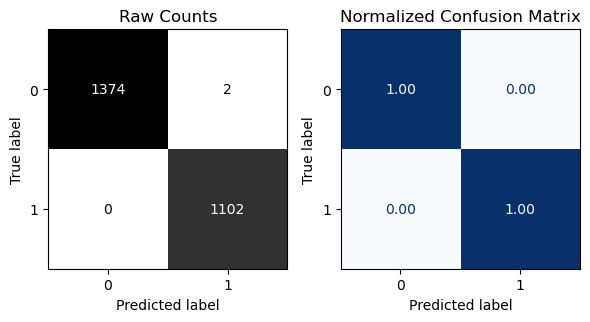


- Evaluating Training Data:
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9998 - loss: 0.0047 - recall: 1.0000
{'accuracy': 0.9991928935050964, 'loss': 0.005624478217214346, 'recall': 1.0}
----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.96      0.91      0.94       238
           1       0.89      0.95      0.92       176

    accuracy                           0.93       414
   macro avg       0.93      0.93      0.93       414
weighted avg       0.93      0.93      0.93       414



2024-09-05 12:15:51.313545: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


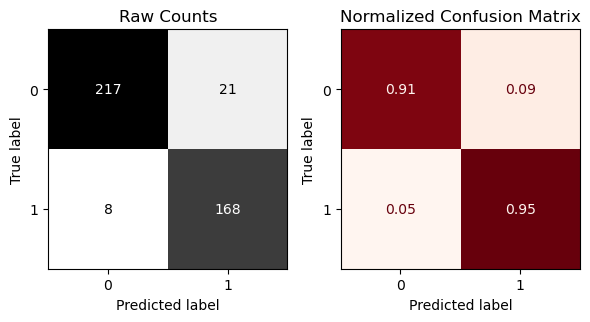


- Evaluating Test Data:
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9334 - loss: 0.2253 - recall: 0.9426
{'accuracy': 0.9299516677856445, 'loss': 0.24098041653633118, 'recall': 0.9545454382896423}


In [61]:
# Obtain the results
results = fn.evaluate.evaluate_classification_network(
    bidirection_model, X_train=train_ds, 
    X_test=test_ds,# history=history
);

In [62]:
# # Saving model in tf format 
# fname_model_gru = FPATHS['models']['nn']['GRU_dir']# "Models/keras/lstm/" # Filename is a folder for save_format='tf'
# bidirection_model.save(fname_model_gru, save_format='tf')

## Attention model

In [63]:
from tensorflow.keras.layers import MultiHeadAttention
from tensorflow.keras import models

def build_attention_model(text_vectorization_layer, binary_task=True):
    VOCAB_SIZE = text_vectorization_layer.vocabulary_size()
    
    if binary_task == True:
        final_activation = "sigmoid"  # ?
        loss_func = "binary_crossentropy"
        nunits_output = 1
    else:
        final_activation = "softmax"  # ?
        loss_func = "sparse_categorical_crossentropy"
        nunits_output = len(classes)

    # Input layer
    input_layer = layers.Input(shape=(SEQUENCE_LENGTH,), dtype=tf.string) 
    flattened_input = tf.reshape(input_layer, (-1,))
    

    # Vectorization and embedding
    x = text_vectorization_layer(flattened_input)
    x = layers.Embedding(input_dim=VOCAB_SIZE, output_dim=EMBED_DIM, input_length=SEQUENCE_LENGTH)(x)

    # MultiHeadAttention
    # In this case, using the same tensor for query, key, and value
    attention_output = layers.MultiHeadAttention(num_heads=4, key_dim=200, value_dim=EMBED_DIM)(x, x, x)
    x = layers.Flatten()(attention_output)

    # Further layers
    x = layers.Dense(128, activation='relu')(x)
    outputs = layers.Dense(nunits_output, activation=final_activation)(x)

    # Model creation
    model = models.Model(inputs=input_layer, outputs=outputs)

    # optimizer = optimizers.legacy.Adam()
    # Compile the model
    lr_schedule = optimizers.schedules.ExponentialDecay(
        initial_learning_rate=0.01, decay_steps=10000, decay_rate=0.95
    )  # 0.9)
    optimizer = optimizers.Adam(learning_rate=lr_schedule)
    
    model.compile(optimizer=optimizer, 
                  loss=loss_func,
                              metrics=[  # tf.metrics.Accuracy(name='accuracy'),
            "accuracy",
            tf.metrics.Recall(name="recall")
                              ])
    model.summary()
    return model


In [64]:
# # Build the lstm model and specify the vectorizer
# attention_model = build_attention_model(sequence_vectorizer, binary_task=True)

# # Defien number of epocs
# EPOCHS = 30

# # Fit the model
# history = attention_model.fit(
#     train_ds,
#     epochs=EPOCHS,
#     validation_data=val_ds,
#     callbacks=get_callbacks(),
# )
# fn.evaluate.plot_history(history)

In [65]:
# # Obtain the results
# results = fn.evaluate.evaluate_classification_network(
#     attention_model, X_train=train_ds, 
#     # X_test=test_ds,# history=history
# );